In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.ticker as ticker
import seaborn as sns
from copy import deepcopy

In [2]:
# Own implementations
%load_ext autoreload
%autoreload 2
from data_generation import *

# Misc
import sys
sys.path.insert(0, '../misc')
from plots import *

plt.style.use('../misc/report.mplstyle')
save_dir = "../../../tex/01_regression_resampling/img/"

In [3]:
save=True

In [463]:
def plot_franke_3d(ax, X, Y, fXY, x=None, y=None, z=None, zmin=0, zmax=1, **kwargs):
    
    ax.plot_surface(X, Y, fXY, **kwargs, vmin=np.min(fXY), vmax=np.max(fXY))
    if x is not None and y is not None and z is not None:
        ax.scatter(x[lower],y[lower],z[lower],zorder=20,alpha=0.8,s=2,color="blue",marker="v")
        ax.scatter(x[higher],y[higher],z[higher],zorder=20,alpha=1,s=2,color="red",marker="^")
    
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax.set_zlim([zmin,zmax])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.text(-0.1,-0.1,1.2,r"$z$")

    # Hack to change axis origin. matplotlib really shows that it is not
    # meant for 3d plotting at this point:(
    tmp_planes = ax.xaxis._PLANES 
    ax.xaxis._PLANES = ( tmp_planes[0], tmp_planes[0], 
                         tmp_planes[1], tmp_planes[0], 
                         tmp_planes[0], tmp_planes[0])

    tmp_planes = ax.yaxis._PLANES 
    ax.yaxis._PLANES = ( tmp_planes[1], tmp_planes[0], 
                         tmp_planes[0], tmp_planes[0], 
                         tmp_planes[0], tmp_planes[0])

    tmp_planes = ax.zaxis._PLANES 
    ax.zaxis._PLANES = ( tmp_planes[1], tmp_planes[0], 
                         tmp_planes[0], tmp_planes[0], 
                         tmp_planes[0], tmp_planes[0])

    ax.view_init(15,50)

    ax.grid(False)
    for a in [ax.xaxis, ax.yaxis, ax.zaxis]:
        a.set_major_locator(ticker.FixedLocator([1]))
    ax.zaxis.set_major_locator(ticker.FixedLocator([zmin,zmax]))
    #ax.axes.zaxis.set_ticklabels([1])

    ax.tick_params(axis='both', which='major', pad=0)
    return ax

/tmp/ipykernel_49719/4146169268.py:50: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


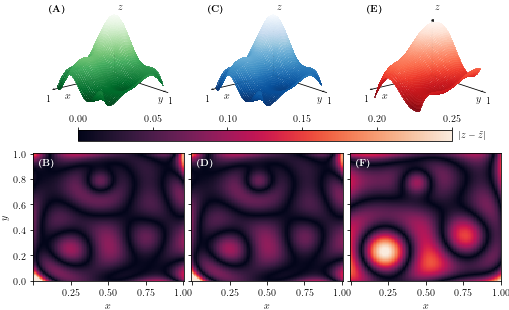

In [503]:
# Load trained, optimal predictors and models (design matrix specs) from 0{1,2,3}_*_ notebooks
%store -r ols_opt
%store -r ols_popt_cv
%store -r ridge_opt
%store -r ridge_popt_cv
%store -r lasso_opt
%store -r lasso_popt_bs

N_uniform = 100
x = np.linspace(0,1,N_uniform)
y = np.linspace(0,1,N_uniform)

#Form cartesian prodcut of x and y
xy = np.array([X,Y]).T.reshape(-1,2)
xx, yy = np.meshgrid(x,y)
fXY = franke_function(X,Y)

kwargs_base = {"lw":2, 
          "antialiased":False,
          "alpha":0.8,
          "linewidth":0,
            
          "zorder":1
         }
kwargs_ols = deepcopy(kwargs_base)
kwargs_ridge = deepcopy(kwargs_base)
kwargs_lasso = deepcopy(kwargs_base)
kwargs_ols["cmap"] = sns.color_palette("Greens_r", as_cmap=True)
kwargs_ridge["cmap"] = sns.color_palette("Blues_r", as_cmap=True)
kwargs_lasso["cmap"] = sns.color_palette("Reds_r", as_cmap=True)

cmap_residual = sns.color_palette("rocket", as_cmap=True)
kwargs_res = {"lw":2, 
              "antialiased":False,
              "linewidth":0,
              "cmap":cmap_residual,
              "shading":'auto',
              "vmin":0,
              "vmax":.25,
              "edgecolor": "face",
              "rasterized":True,
              "linewidth": 0
            
}

fig = plt.figure(figsize=(8.4,8.4*0.618))

ax_ols = fig.add_subplot(2, 3, 1, projection='3d')
ax_ridge = fig.add_subplot(2, 3, 2, projection='3d')
ax_lasso = fig.add_subplot(2, 3, 3, projection='3d')
ax_ols_residual = fig.add_subplot(2, 3, 4)
ax_ridge_residual = fig.add_subplot(2, 3, 5)
ax_lasso_residual = fig.add_subplot(2, 3, 6)

cbar_ax = fig.add_axes([0.2, 0.5, 0.618, 0.03])
cbar_ax.text(1.02, 0.5, r"$| z-\tilde{z}|$", va="center", transform=cbar_ax.transAxes)

ax_ridge_residual.yaxis.set_ticklabels([])
ax_lasso_residual.yaxis.set_ticklabels([])
for ax in [ax_ols_residual,ax_ridge_residual,ax_lasso_residual]:
    ax.set_xlabel(r"$x$")
ax_ols_residual.set_ylabel(r"$y$")


predictor_representation = [
    (ols_popt_cv, ols_opt, ax_ols, ax_ols_residual, kwargs_ols, r"\textbf{(A)}", r"\textbf{(B)}"),
    (ridge_popt_cv, ridge_opt, ax_ridge, ax_ridge_residual,kwargs_ridge, r"\textbf{(C)}", r"\textbf{(D)}"),
    (lasso_popt_bs, lasso_opt, ax_lasso, ax_lasso_residual,kwargs_lasso, r"\textbf{(E)}", r"\textbf{(F)}")
]

for (p_opt, predictor_opt, ax, ax_residual, kwargs, label, label_res) in predictor_representation:
    
    Xvis = generate_design_matrix(xy[:,0],xy[:,1],p_opt)
    zvis = predictor_opt.predict(Xvis).reshape(N_uniform,N_uniform).T

    plot_franke_3d(ax,xx,yy,zvis,**kwargs)
    ax.text2D(0.04, 0.9, label, transform=ax.transAxes)
    
    im = ax_residual.pcolormesh(xx, yy, np.abs(zvis - fXY), **kwargs_res)
    ax_residual.text(0.04, 0.9, label_res, transform=ax_residual.transAxes, c="white")
    
fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar_ax.xaxis.set_ticks_position('top')
    
plt.subplots_adjust(wspace=0.05, hspace=0.2)

fig.canvas.draw()
for ax in [ax_ols_residual,ax_ridge_residual,ax_lasso_residual]:
    plt.setp(ax.get_xticklabels()[1], visible=False)

if save:
    fig.savefig(save_dir + "regression_comparison.pdf",bbox_inches="tight",pad_inches = 0.01)
else:
    plt.show()